# Modelling, Part 1: using all features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pickle
import pathlib
import tqdm
import numpy as np
import numpy.random
import pandas as pd
from sklearn import svm
import sklearn.metrics as metr
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.neighbors.nearest_centroid as nc
import sklearn.neighbors as ne
import sklearn.naive_bayes as nb
import sklearn.ensemble as em
import sklearn.discriminant_analysis as da
import sklearn.gaussian_process as gp
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.base import clone
import sklearn.model_selection as ms
import gestureanalysis.svm_helpers as svmhelper
import sklearn.utils
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
base_path = "/home/jsimon/Documents/thesis/gesture-analysis/data/"
time_groups_path_corrected_pickl = base_path+"transformed/time_added/all/time-and-groups-corrected-all.pkl"
stats_added_base_path = base_path+"transformed/stats_added/all/"
stats_added_path_pickl = stats_added_base_path+"raw_stats-added-all.pkl"
gyro_calibration_path = base_path+'../scripts/gestureanalysis/gyro_offset.txt'

In [4]:
import os
os.getcwd()

'/home/jsimon/Documents/thesis/gesture-analysis/scripts'

In [5]:
with open( stats_added_base_path+'train-data-scaled-noconst.pkl', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)

In [6]:
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']

In [7]:
X, y = sklearn.utils.shuffle(X, y)

In [8]:
del [[data]]
gc.collect()
data = pd.DataFrame()
gc.collect()

0

## Give the classifiers who can handle the data with the variance theshold a chance

In [9]:
# start with some list, and remove then when the classifier takes too long
classifiers = [# ("lin svc",svm.LinearSVC(class_weight='balanced')), takes too long (stopped after 2h)
               # ("gaussian process", gp.GaussianProcessClassifier()), Memory error
               # ("gaussian process w. restarts", gp.GaussianProcessClassifier(n_restarts_optimizer=3)), , Memory error
               # ("lr",lm.LogisticRegression(class_weight='balanced')), # kernel died
               ("passive agressive", lm.PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight='balanced')),
               # ("lr(l1)",lm.LogisticRegression(penalty='l1', class_weight='balanced')), # kernel died
               ("sgd[hinge]",lm.SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, class_weight='balanced')),
               ("LDA", da.LinearDiscriminantAnalysis()),
               ("QDA", da.QuadraticDiscriminantAnalysis()),
               ("nn",nc.NearestCentroid()),
               #("knn",ne.KNeighborsClassifier()), # fitting worked, but prediction takes to long as this scales with the data
               #("rnc",ne.RadiusNeighborsClassifier(radius=3.0)), # could not find a good distance, tried 1 and 3
               ("gaussian navie bayse",nb.GaussianNB()),
               # ("decision tree",tree.DecisionTreeClassifier(class_weight='balanced')), # timed out
               ("random forrest",em.RandomForestClassifier(n_estimators=10, class_weight='balanced', n_jobs=3, verbose=True)),
               ("extra trees",em.ExtraTreesClassifier(n_estimators=10, class_weight='balanced', n_jobs=3, verbose=True))
               # ("bagging kn",em.BaggingClassifier(ne.KNeighborsClassifier(),max_samples=0.5, max_features=0.5, verbose=True)), timed out after 1h
               # ("bagging svc",em.BaggingClassifier(svm.SVC(decision_function_shape='ovo', class_weight='balanced'),max_samples=0.5, n_jobs=3, max_features=0.5, verbose=True)), # timed out after 1h
               # ("ada boost",em.AdaBoostClassifier(n_estimators=100)), # timed out
               #("gradient boost",em.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, verbose=True)) # timed out, says after 1h running that it still has 758m open
]


In [10]:
def fit_classifier(classifiers, X, y, Xval, yval):
    clf = None
    clf_n = None
    
    results = []
    progress = tqdm.tqdm_notebook(classifiers)
    for clf_name, clf_candidate in progress:
        progress.set_description(clf_name)
        clf_candidate = clone(clf_candidate)
        gc.collect()
        progress.set_description(clf_name + ' cloned')
        clf_candidate.fit(X, y)
        progress.set_description(clf_name + ' fittet')
        p = clf_candidate.predict(Xval)
        s = f1_score(yval, p, average='micro')
        p_t = clf_candidate.predict(X)
        s_t = f1_score(y, p_t, average='micro')
        print(f"val score {s} for {clf_name} (test: {s_t})")
        cmatrix = metr.confusion_matrix(yval, p)
        #print(cmatrix)
        results.append((clf_name, s, s_t, cmatrix, clf_candidate))
        gc.collect()

    return results

In [11]:
gc.collect()
results = fit_classifier(classifiers, X, y, Xval, yval)

val score 0.4104429356611704 for passive agressive (test: 0.5026414121891509)
val score 0.08874878758486907 for sgd[hinge] (test: 0.2881587424300992)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9494018752020692 for LDA (test: 0.9461796160288622)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.6215648237956677 for QDA (test: 0.8896533951810334)
val score 0.08115098609763984 for nn (test: 0.0914572864321608)
val score 0.2146783058519237 for gaussian navie bayse (test: 0.1306532663316583)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9602327837051406 for random forrest (test: 0.9977451359360907)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9634658907209829 for extra trees (test: 1.0)



In [12]:
# if you recompute: this is the 1910 set in reality
with open( stats_added_base_path+'full-clss.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

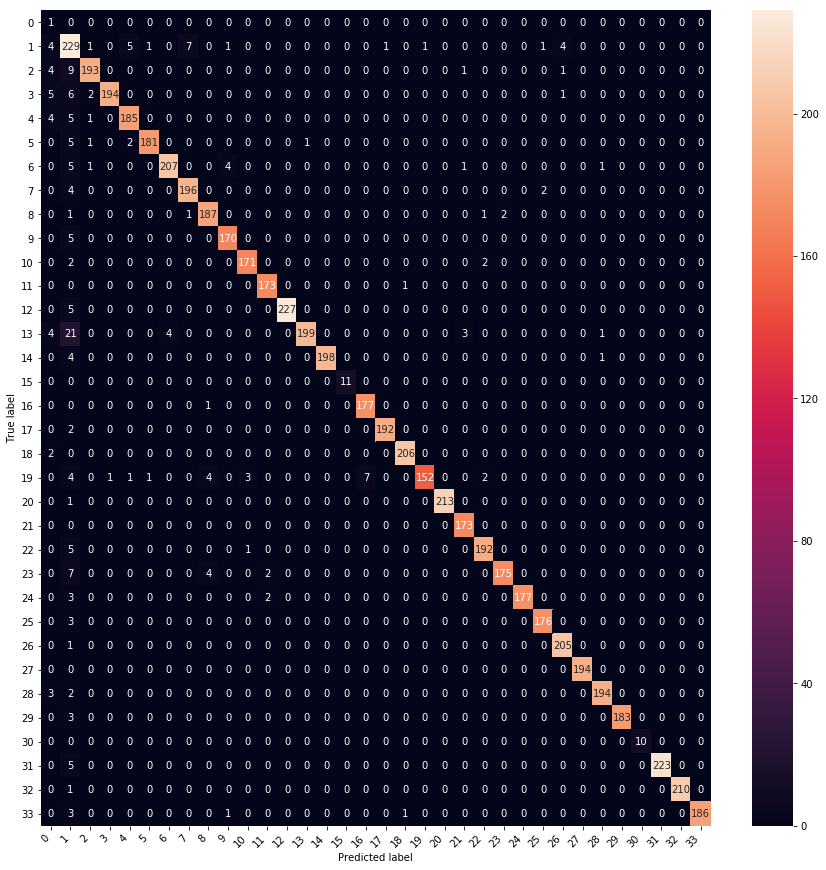

In [13]:
f, axarr = plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(results[-1][3], annot=True, fmt="d", ax=axarr)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## SVM: the quest to find C

In [ ]:
classifiers = svmhelper.get_svm_grid()

In [ ]:
def find_classifier_hyperparams(classifiers, X, y):
    clf = None
    clf_n = None
    kf = StratifiedKFold(n_splits=4)
    kf.get_n_splits(X, y)
    score = 0
    
    results = []
    for clf_name, clf_candidate, needsScaledData in tqdm.tqdm_notebook(classifiers):
        clf_candidate = clone(clf_candidate)
        print("KFold fit {}".format(clf_name))
        # decide: we should return the best model for each classifier here?
        # and do we pickle them?
        fitted_clfs = []
        for train_index, test_index in tqdm.tqdm_notebook(kf.split(X, y), leave=False):
            X_train = X[train_index, :]
            X_ct = X[test_index, :]
            y_train = y[train_index]
            y_ct = y[test_index]
            clf_candidate.fit(X_train, y_train)
            p = clf_candidate.predict(X_ct)
            s = f1_score(y_ct, p, average='micro')
            p_t = clf_candidate.predict(X_train)
            s_t = f1_score(y_train, p_t, average='micro')
            print(f"val score {s} for {clf_name} (test: {s_t})")
            cmatrix = metr.confusion_matrix(y_ct, clf_candidate.predict(X_ct))
            print(cmatrix)
            fitted_clfs.append((s, clf_candidate))
            #cscore = cmatrix[1,1] + cmatrix[2,2] + cmatrix[3,3]
            #if s > score:
            #    score = s
            #    clf = clf_candidate
            #    clf_n = clf_name
        results.append((clf_name, fitted_clfs))
    
    best_average = 0.0
    best_av_clf = None
    best_clf_name = None
    for name, clfs in results:
        sorted_clfs = sorted(clfs, key=lambda tup: tup[0])
        average_score, avarage_clf = sorted_clfs[len(clfs)//2]
        if average_score > best_average:
            best_average = average_score
            best_av_clf = avarage_clf
            best_clf_name = name

    return (best_av_clf, best_clf_name, True, minmax)

In [ ]:
X_samples, y_samples = subsample(candiate2,y,3)

In [ ]:
gc.collect()
find_classifier_hyperparams(classifiers, X, y)